# Case-Explainer Tutorial: Credit Card Fraud Detection

This tutorial demonstrates case-based explainability in the **financial security domain** with highly imbalanced data.

## Financial Context

In fraud detection, analysts often identify fraud by comparing transactions to known fraud patterns:

> *"This transaction is flagged as fraudulent because it closely resembles these 5 confirmed fraud cases"*

## Dataset Challenges

- **284,807 transactions** - European cardholders (Sept 2013)
- **30 features** - PCA-transformed for privacy (V1-V28, Time, Amount)
- **Extreme imbalance** - Only 0.17% fraud (492/284,807)
- **Financial impact** - False negatives cost money, false positives annoy customers

## What You'll Learn

- Handling extreme class imbalance
- Understanding fraud detection confidence
- Analyzing false positives vs false negatives
- Using correspondence for alert prioritization

## 1. Setup and Data Loading

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

sys.path.insert(0, '..')
from case_explainer import CaseExplainer

np.random.seed(42)
sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
# Load fraud detection dataset
# Note: You need creditcard.csv from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv('../creditcard.csv')

X = df.drop('Class', axis=1).values
y = df['Class'].values  # 0=legitimate, 1=fraud
feature_names = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount']
class_names = {0: 'legitimate', 1: 'fraud'}

# Split with stratification (important for imbalanced data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Dataset: {len(X):,} transactions")
print(f"Training: {len(X_train):,} transactions")
print(f"Testing: {len(X_test):,} transactions")
print(f"\nFeatures: {len(feature_names)} (PCA-transformed for privacy)")
print(f"\nClass distribution (training):")
for i, name in class_names.items():
    count = np.sum(y_train == i)
    pct = count / len(y_train) * 100
    print(f"  {name}: {count:,} ({pct:.3f}%)")

fraud_rate = np.sum(y_train == 1) / len(y_train) * 100
print(f"\nWARNING: Extreme imbalance: Only {fraud_rate:.3f}% fraud!")

Dataset: 284,807 transactions
Training: 199,364 transactions
Testing: 85,443 transactions

Features: 30 (PCA-transformed for privacy)

Class distribution (training):
  legitimate: 199,020 (99.827%)
  fraud: 344 (0.173%)



## 2. Train Fraud Detection Model

We use class weights to handle the severe imbalance.

Accuracy: 99.945%
ROC-AUC: 92.754%

Classification Report:
              precision    recall  f1-score   support

  legitimate     0.9995    1.0000    0.9997     85295
       fraud     0.9720    0.7027    0.8157       148

    accuracy                         0.9994     85443
   macro avg     0.9857    0.8513    0.9077     85443
weighted avg     0.9994    0.9994    0.9994     85443



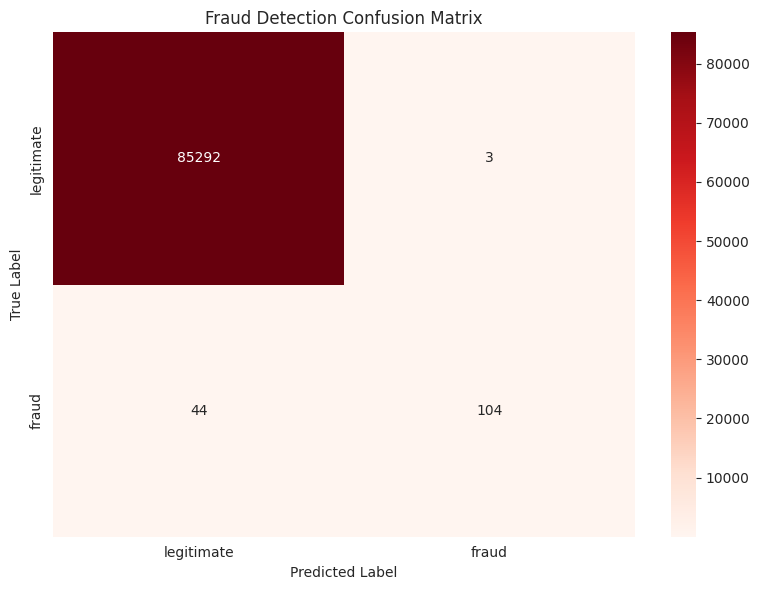


Financial Impact Analysis:
  True Positives (caught fraud): 104
  False Negatives (missed fraud): 44
  False Positives (false alarms): 3
  Fraud detection rate: 70.3%


In [9]:
# Train with class weights to handle imbalance
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # Critical for imbalanced data
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.3%}")
print(f"ROC-AUC: {auc:.3%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(class_names.values()), digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Fraud Detection Confusion Matrix')
plt.tight_layout()
plt.show()

# Calculate financial metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nFinancial Impact Analysis:")
print(f"  True Positives (caught fraud): {tp}")
print(f"  False Negatives (missed fraud): {fn}")
print(f"  False Positives (false alarms): {fp}")
print(f"  Fraud detection rate: {tp/(tp+fn)*100:.1f}%")

## 3. Create Fraud Detection Explainer

The explainer will find similar transactions to explain fraud predictions.

In [10]:
# Create explainer with ball_tree and scaling
explainer = CaseExplainer(
    X_train=X_train,
    y_train=y_train,
    feature_names=feature_names,
    class_names=class_names,
    algorithm='ball_tree',
    scale_data=True
)

print(f"Fraud detection database initialized with {len(X_train):,} transactions")
print(f"  Legitimate: {np.sum(y_train==0):,}")
print(f"  Fraud: {np.sum(y_train==1):,}")

Building k-NN index (k=5, metric=euclidean, algorithm=ball_tree)...
Index built on 199364 training samples
Fraud detection database initialized with 199,364 transactions
  Legitimate: 199,020
  Fraud: 344


## 4. Explain a Fraud Detection

Let's examine how the model identifies a fraudulent transaction.

In [11]:
# Find a fraud case to explain
fraud_indices = np.where(y_test == 1)[0]
fraud_idx = fraud_indices[0] if len(fraud_indices) > 0 else 0

test_transaction = X_test[fraud_idx]
true_label = y_test[fraud_idx]

# Get explanation
explanation = explainer.explain_instance(
    test_sample=test_transaction,
    k=5,
    model=clf,
    true_class=true_label
)

print("=" * 70)
print("FRAUD DETECTION EXPLANATION")
print("=" * 70)
print(f"\nPrediction: {class_names[explanation.predicted_class].upper()}")
print(f"True label: {class_names[explanation.true_class].upper()}")
print(f"Correct detection: {explanation.is_correct()}")
print(f"\nDetection confidence (correspondence): {explanation.correspondence:.1%}")
print(f"Confidence level: {explanation.correspondence_interpretation}")

print(f"\n{'='*70}")
print("SIMILAR TRANSACTIONS:")
print(f"{'='*70}")
for i, neighbor in enumerate(explanation.neighbors, 1):
    print(f"\n{i}. Transaction #{neighbor.index}")
    print(f"   Label: {class_names[neighbor.label]}")
    print(f"   Similarity: {1/(neighbor.distance+1):.3f}")
    print(f"   Distance: {neighbor.distance:.3f}")

FRAUD DETECTION EXPLANATION

Prediction: FRAUD
True label: FRAUD
Correct detection: True

Detection confidence (correspondence): 100.0%
Confidence level: high

SIMILAR TRANSACTIONS:

1. Transaction #171514
   Label: fraud
   Similarity: 0.167
   Distance: 4.990

2. Transaction #140299
   Label: fraud
   Similarity: 0.143
   Distance: 5.989

3. Transaction #143162
   Label: fraud
   Similarity: 0.140
   Distance: 6.133

4. Transaction #195687
   Label: fraud
   Similarity: 0.126
   Distance: 6.946

5. Transaction #119277
   Label: fraud
   Similarity: 0.120
   Distance: 7.299


### Fraud Detection Interpretation

**High Correspondence (≥85%)**
- Strong match to known fraud patterns
- High-priority alert
- Immediate action recommended

**Medium Correspondence (70-85%)**
- Moderate match to fraud patterns
- Review recommended
- May need additional verification

**Low Correspondence (<70%)**
- Weak match to known patterns
- Novel fraud type OR false positive
- Manual review essential

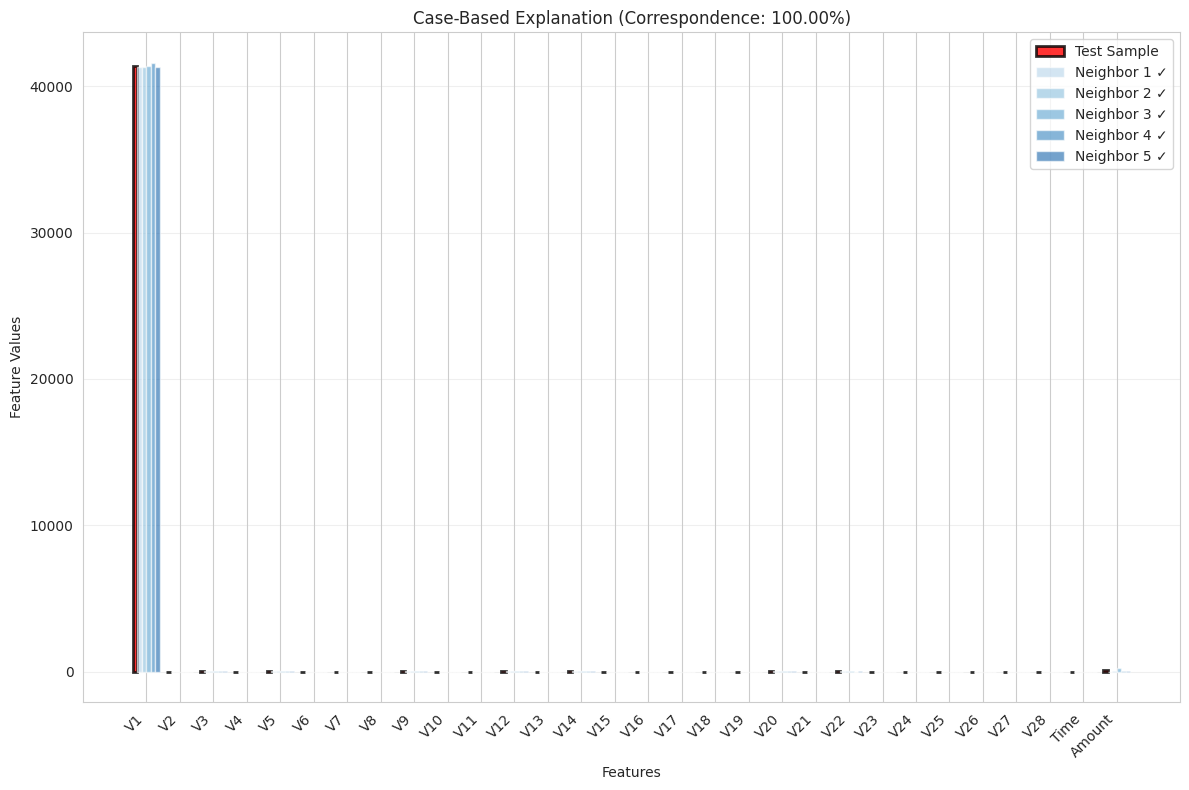

In [12]:
# Visualize explanation
explanation.plot(plot_type='bar')

## 5. Batch Analysis: All Test Transactions

Generate explanations for a sample of test transactions.

In [13]:
# Sample transactions for analysis (full dataset would take long)
# Include all fraud cases + random sample of legitimate
fraud_mask = y_test == 1
legit_indices = np.where(~fraud_mask)[0]
fraud_indices = np.where(fraud_mask)[0]

# Sample 1000 legitimate + all fraud
sample_legit = np.random.choice(legit_indices, min(1000, len(legit_indices)), replace=False)
sample_indices = np.concatenate([sample_legit, fraud_indices])

X_sample = X_test[sample_indices]
y_sample = y_test[sample_indices]

print(f"Analyzing {len(sample_indices)} transactions...")
print(f"  Legitimate: {np.sum(y_sample==0)}")
print(f"  Fraud: {np.sum(y_sample==1)}")
print("\nThis may take a minute...")

# Generate explanations
explanations = explainer.explain_batch(
    X_test=X_sample,
    k=5,
    y_test=y_sample,
    model=clf
)

print(f"\nGenerated {len(explanations)} explanations")

Analyzing 1148 transactions...
  Legitimate: 1000
  Fraud: 148

This may take a minute...

Generated 1148 explanations


## 6. Correspondence Analysis

In [14]:
# Extract metrics
correspondences = [exp.correspondence for exp in explanations]
correct_corr = [exp.correspondence for exp in explanations if exp.is_correct()]
incorrect_corr = [exp.correspondence for exp in explanations if not exp.is_correct()]

# Separate by predicted class
fraud_pred_corr = [exp.correspondence for exp in explanations if exp.predicted_class == 1]
legit_pred_corr = [exp.correspondence for exp in explanations if exp.predicted_class == 0]

print(f"Correspondence Statistics:\n")
print(f"Overall mean: {np.mean(correspondences):.1%}")
print(f"Correct predictions: {np.mean(correct_corr):.1%}")
if incorrect_corr:
    print(f"Incorrect predictions: {np.mean(incorrect_corr):.1%}")
    print(f"Confidence gap: {np.mean(correct_corr) - np.mean(incorrect_corr):.1%}")

print(f"\nBy Predicted Class:")
print(f"Fraud alerts: {np.mean(fraud_pred_corr):.1%} avg correspondence")
print(f"Legitimate: {np.mean(legit_pred_corr):.1%} avg correspondence")

# Priority distribution
high = sum(1 for exp in explanations if exp.correspondence >= 0.85)
medium = sum(1 for exp in explanations if 0.70 <= exp.correspondence < 0.85)
low = sum(1 for exp in explanations if exp.correspondence < 0.70)

print(f"\nAlert Priority Distribution:")
print(f"  High priority (≥85%): {high} ({high/len(explanations)*100:.1f}%)")
print(f"  Medium priority (70-85%): {medium} ({medium/len(explanations)*100:.1f}%)")
print(f"  Low priority (<70%): {low} ({low/len(explanations)*100:.1f}%)")

Correspondence Statistics:

Overall mean: 98.4%
Correct predictions: 99.4%
Incorrect predictions: 73.0%
Confidence gap: 26.5%

By Predicted Class:
Fraud alerts: 94.1% avg correspondence
Legitimate: 98.8% avg correspondence

Alert Priority Distribution:
  High priority (≥85%): 1114 (97.0%)
  Medium priority (70-85%): 9 (0.8%)
  Low priority (<70%): 25 (2.2%)


## 7. False Positive Analysis

In fraud detection, false positives (false alarms) annoy customers.

In [15]:
# Analyze errors
false_positives = [exp for exp in explanations 
                  if exp.predicted_class == 1 and exp.true_class == 0]
false_negatives = [exp for exp in explanations 
                  if exp.predicted_class == 0 and exp.true_class == 1]

print("Error Analysis:\n")
print(f"False Positives (false alarms): {len(false_positives)}")
if false_positives:
    fp_corr = [exp.correspondence for exp in false_positives]
    print(f"  Average correspondence: {np.mean(fp_corr):.1%}")
    print(f"  Interpretation: Low correspondence suggests weak fraud pattern match")
    print(f"  Recommendation: These need careful manual review")

print(f"\nFalse Negatives (missed fraud): {len(false_negatives)}")
if false_negatives:
    fn_corr = [exp.correspondence for exp in false_negatives]
    print(f"  Average correspondence: {np.mean(fn_corr):.1%}")
    print(f"  Interpretation: These fraud cases look like legitimate transactions")
    print(f"  Recommendation: May be novel fraud patterns - update training data")

# True positives (caught fraud)
true_positives = [exp for exp in explanations 
                 if exp.predicted_class == 1 and exp.true_class == 1]
if true_positives:
    tp_corr = [exp.correspondence for exp in true_positives]
    print(f"\nTrue Positives (caught fraud): {len(true_positives)}")
    print(f"  Average correspondence: {np.mean(tp_corr):.1%}")
    print(f"  Interpretation: High correspondence = strong fraud pattern match")

Error Analysis:

False Positives (false alarms): 0

False Negatives (missed fraud): 44
  Average correspondence: 73.0%
  Interpretation: These fraud cases look like legitimate transactions
  Recommendation: May be novel fraud patterns - update training data

True Positives (caught fraud): 104
  Average correspondence: 94.1%
  Interpretation: High correspondence = strong fraud pattern match


## 8. Visualize Correspondence Distributions

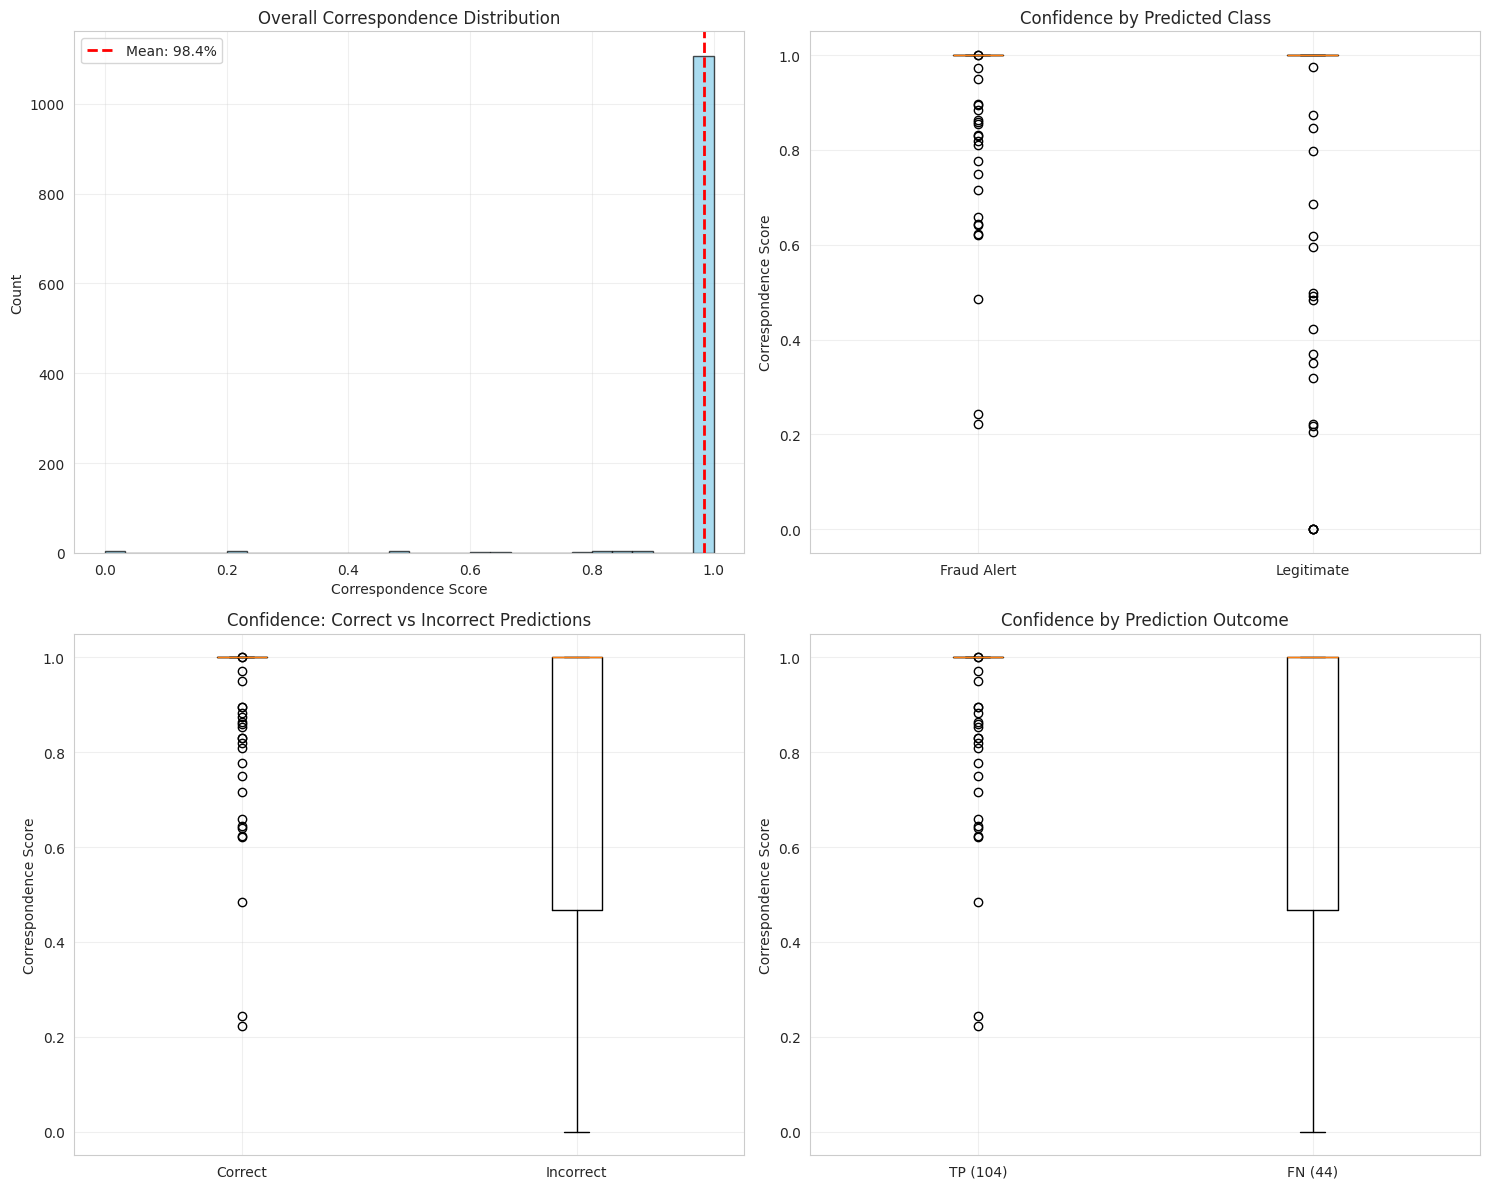

In [17]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall distribution
axes[0, 0].hist(correspondences, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(np.mean(correspondences), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(correspondences):.1%}')
axes[0, 0].set_xlabel('Correspondence Score')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Overall Correspondence Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. By prediction type
axes[0, 1].boxplot([fraud_pred_corr, legit_pred_corr], 
                   tick_labels=['Fraud Alert', 'Legitimate'])
axes[0, 1].set_ylabel('Correspondence Score')
axes[0, 1].set_title('Confidence by Predicted Class')
axes[0, 1].grid(alpha=0.3)

# 3. Correct vs Incorrect
if incorrect_corr:
    axes[1, 0].boxplot([correct_corr, incorrect_corr], 
                       tick_labels=['Correct', 'Incorrect'])
    axes[1, 0].set_ylabel('Correspondence Score')
    axes[1, 0].set_title('Confidence: Correct vs Incorrect Predictions')
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'All predictions correct!', 
                   ha='center', va='center', fontsize=14)
    axes[1, 0].set_title('Perfect Accuracy')

# 4. Error type comparison
if false_positives or false_negatives or true_positives:
    fp_corr = [exp.correspondence for exp in false_positives] if false_positives else []
    fn_corr = [exp.correspondence for exp in false_negatives] if false_negatives else []
    tp_corr = [exp.correspondence for exp in true_positives] if true_positives else []
    
    data_to_plot = []
    labels = []
    if tp_corr:
        data_to_plot.append(tp_corr)
        labels.append(f'TP ({len(tp_corr)})')
    if fp_corr:
        data_to_plot.append(fp_corr)
        labels.append(f'FP ({len(fp_corr)})')
    if fn_corr:
        data_to_plot.append(fn_corr)
        labels.append(f'FN ({len(fn_corr)})')
    
    axes[1, 1].boxplot(data_to_plot, tick_labels=labels)
    axes[1, 1].set_ylabel('Correspondence Score')
    axes[1, 1].set_title('Confidence by Prediction Outcome')
    axes[1, 1].grid(alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Perfect detection - no errors!', 
                   ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Perfect Detection')

plt.tight_layout()
plt.show()

## 9. Alert Prioritization System

Use correspondence to prioritize fraud alerts for manual review.

In [18]:
# Get fraud alerts
fraud_alerts = [exp for exp in explanations if exp.predicted_class == 1]

if fraud_alerts:
    # Sort by correspondence (high = strong fraud pattern)
    fraud_alerts.sort(key=lambda x: x.correspondence, reverse=True)
    
    print(f"FRAUD ALERT PRIORITIZATION")
    print(f"{'='*70}\n")
    print(f"Total fraud alerts: {len(fraud_alerts)}\n")
    
    # High priority
    high_priority = [exp for exp in fraud_alerts if exp.correspondence >= 0.85]
    print(f"HIGH PRIORITY (>=85% correspondence): {len(high_priority)} alerts")
    print("   Action: Immediate investigation/blocking")
    print("   Reason: Strong match to known fraud patterns\n")
    
    # Medium priority
    med_priority = [exp for exp in fraud_alerts 
                   if 0.70 <= exp.correspondence < 0.85]
    print(f"MEDIUM PRIORITY (70-85% correspondence): {len(med_priority)} alerts")
    print("   Action: Review within 24 hours")
    print("   Reason: Moderate fraud pattern match\n")
    
    # Low priority
    low_priority = [exp for exp in fraud_alerts if exp.correspondence < 0.70]
    print(f"LOW PRIORITY (<70% correspondence): {len(low_priority)} alerts")
    print("   Action: Careful manual review")
    print("   Reason: Weak pattern match - may be false positive or novel fraud")
    
    # Show top 5 high-priority cases
    if high_priority:
        print(f"\n{'='*70}")
        print("TOP 5 HIGH-PRIORITY ALERTS:")
        print(f"{'='*70}")
        for i, exp in enumerate(high_priority[:5], 1):
            status = "CORRECT" if exp.is_correct() else "FALSE POSITIVE"
            print(f"\n{i}. Alert (test index {exp.test_index})")
            print(f"   Correspondence: {exp.correspondence:.1%}")
            print(f"   True label: {class_names[exp.true_class]}")
            print(f"   Status: {status}")
else:
    print("No fraud alerts in sample")

FRAUD ALERT PRIORITIZATION

Total fraud alerts: 104

HIGH PRIORITY (>=85% correspondence): 89 alerts
   Action: Immediate investigation/blocking
   Reason: Strong match to known fraud patterns

MEDIUM PRIORITY (70-85% correspondence): 7 alerts
   Action: Review within 24 hours
   Reason: Moderate fraud pattern match

LOW PRIORITY (<70% correspondence): 8 alerts
   Action: Careful manual review
   Reason: Weak pattern match - may be false positive or novel fraud

TOP 5 HIGH-PRIORITY ALERTS:

1. Alert (test index 1000)
   Correspondence: 100.0%
   True label: fraud
   Status: CORRECT

2. Alert (test index 1001)
   Correspondence: 100.0%
   True label: fraud
   Status: CORRECT

3. Alert (test index 1002)
   Correspondence: 100.0%
   True label: fraud
   Status: CORRECT

4. Alert (test index 1003)
   Correspondence: 100.0%
   True label: fraud
   Status: CORRECT

5. Alert (test index 1004)
   Correspondence: 100.0%
   True label: fraud
   Status: CORRECT


## Key Financial Insights

### 1. Handling Extreme Imbalance
- Only 0.17% fraud in dataset
- Class weights essential for training
- Correspondence helps distinguish confident from uncertain fraud predictions

### 2. Alert Prioritization
- **High correspondence**: Strong fraud pattern → immediate action
- **Medium correspondence**: Moderate pattern → review queue
- **Low correspondence**: Weak pattern → careful manual review

### 3. Cost-Benefit Analysis
- **False Negatives**: Lost money (fraud goes through)
- **False Positives**: Customer frustration (legitimate blocked)
- Low correspondence helps identify uncertain cases needing human judgment

### 4. Novel Fraud Detection
- Low correspondence on fraud predictions may indicate:
  - Novel fraud techniques (not in training data)
  - False positives needing manual override
- Both require human expert review

### 5. Operational Recommendations

**High Correspondence Fraud Alerts (≥85%)**
- Automatic blocking or hold
- Contact customer immediately
- High confidence in fraud determination

**Medium Correspondence Alerts (70-85%)**
- Queue for analyst review
- May contact customer for verification
- Additional data may help decision

**Low Correspondence Alerts (<70%)**
- Expert analyst review required
- May be novel fraud OR false positive
- Document patterns for future training

## Next Steps

Try the hardware trojan detection tutorial:
- `04_hardware_trojan_tutorial.ipynb` - Security domain with large-scale data